In [3]:
import sys, os, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
sys.path.insert(0, os.path.join(parent_dir,'spring-break'))
sys.path.insert(0, os.path.join(parent_dir,'Linear\ Classifier'))

In [4]:
import numpy as np
import random
import copy
import math
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from martins.complex_transformer import ComplexTransformer
from FNNLinear import FNNLinear
from FNNSeparated import FNNSeparated
from GAN import Generator, Discriminator
from data_utils import *
import argparse
import logging
import logging.handlers
import pickle
from centerloss import CenterLoss
from FNN import FNN
from GAN import Generator, Discriminator
from sklearn.manifold import TSNE
import seaborn as sns 
import matplotlib.pyplot as plt

# Dataloader

In [5]:
class JoinDataset(Dataset):
    def __init__(self, source_x, source_y, target_x, target_y, random=False):
        self.source_x = source_x
        self.source_y = source_y
        self.target_x = target_x
        self.target_y = target_y
        
        self.source_len = self.source_y.shape[0]
        self.target_len = self.target_y.shape[0]
    
        self.random = random
    def __len__(self):
        return self.target_len
    
    def __getitem__(self, index):
        if self.random:
            index_source = random.randrange(source_len)
            index_target = random.randrange(target_len)
        else:
            index_source = index
            index_target = index

        return (self.source_x[index_source], self.source_y[index_source]), (self.target_x[index_target], self.target_y[index_target])
    
    
class SingleDataset(Dataset):
    def __init__(self, x, y):
            self.x = x
            self.y = y
            self.len = self.y.shape[0]
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]


# Parser

In [6]:
# Parameters
parser = argparse.ArgumentParser(description='JDA Time series adaptation')
parser.add_argument("--data_path", type=str, default="/projects/rsalakhugroup/complex/domain_adaptation", help="dataset path")
parser.add_argument("--task", type=str, help='3A or 3E')
parser.add_argument('--batch_size', type=int, default=256, help='batch size')
parser.add_argument('--epochs', type=int, default=50, help='number of epochs')
parser.add_argument('--lr_gan', type=float, default=1e-3, help='learning rate for adversarial')
parser.add_argument('--lr_centerloss', type=float, default=5e-3, help='learning rate for centerloss')
parser.add_argument('--lr_FNN', type=float, default=1e-3, help='learning rate for classification')
parser.add_argument('--lr_encoder', type=float, default=1e-3, help='learning rate for classification')
parser.add_argument('--lbl_percentage', type=float, default=0.7, help='percentage of which target data has label')
parser.add_argument('--num_per_class', type=int, default=-1, help='number of sample per class when training local discriminator')
parser.add_argument('--seed', type=int, default=0, help='manual seed')
parser.add_argument('--save_path', type=str, help='where to store data')
parser.add_argument('--model_save_period', type=int, default=2, help='period in which the model is saved')
parser.add_argument('--sclass', type=float, default=0.7, help='source domain classification weight on loss function')
parser.add_argument('--scent', type=float, default=0.01, help='source domain classification weight on centerloss')

args = parser.parse_args()


usage: ipykernel_launcher.py [-h] [--data_path DATA_PATH] [--task TASK] [--batch_size BATCH_SIZE] [--epochs EPOCHS] [--lr_gan LR_GAN]
                             [--lr_centerloss LR_CENTERLOSS] [--lr_FNN LR_FNN] [--lr_encoder LR_ENCODER] [--lbl_percentage LBL_PERCENTAGE]
                             [--num_per_class NUM_PER_CLASS] [--seed SEED] [--save_path SAVE_PATH] [--model_save_period MODEL_SAVE_PERIOD]
                             [--sclass SCLASS] [--scent SCENT]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/tianqinli/Library/Jupyter/runtime/kernel-3497996c-23f8-4b2f-8968-42c21931d6c8.json


SystemExit: 2

/Users/tianqinli/anaconda3/envs/russ-local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [7]:
# local only
class local_args:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
args = local_args(**{
    'data_path': '/Users/tianqinli/Code/Russ/time-series-domain-adaptation/data_unzip',
    'task': '3E',
    'num_class': 50,
    'batch_size': 100,
    'num_per_class': -1,
    'gap': 5,
    'lbl_percentage':0.7,
    'lr_gan': 1e-4,
    'lr_FNN': 1e-4,
    'lr_encoder': 1e-4,
    'epochs': 2,
    'clip_value': 0.01,
    'n_critic': 4,
    'sclass': 0.7,
    'scent': 1e-2,
    'seed': None,
    'save_path': '/Users/tianqinli/Code/Russ/time-series-domain-adaptation/train_related',
    'model_save_period': 1,
    'lr_centerloss': 1e-3,
    'seed': 0,
    'select_pretrain_epoch': 509, 
    'sbinary_loss': 1,
    
})

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')

# seed
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
cudnn.deterministic = True
torch.backends.cudnn.deterministic = True


args.task = '3Av2' if args.task == '3A' else '3E'
num_class = 50 if args.task == "3Av2" else 65
device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')

if args.num_per_class == -1:
    args.num_per_class = math.ceil(args.batch_size / num_class)
    
model_sub_folder = '/stepc_binary/task_%s_lrFNN_%f_sbinary_loss_%f'%(args.task, args.lr_FNN, args.sbinary_loss)

if not os.path.exists(args.save_path+model_sub_folder):
    os.makedirs(args.save_path+model_sub_folder)

# Data loading


In [8]:
raw_data = np.load(args.data_path+'/processed_file_not_one_hot_%s.pkl'%args.task, allow_pickle=True)
target_dict, (target_unlabel_x, target_unlabel_y),(target_label_x,target_label_y), target_len  = get_target_dict(args.data_path+'/processed_file_not_one_hot_%s.pkl'%args.task, num_class, args.lbl_percentage)
source_dict, source_len = get_source_dict(args.data_path+'/processed_file_not_one_hot_%s.pkl'%args.task, num_class, data_len=target_len)
join_dataset = JoinDataset(raw_data['tr_data'],raw_data['tr_lbl'],raw_data['te_data'],raw_data['te_lbl'], random=True)
join_dataloader = DataLoader(join_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=4)

source_dataset = SingleDataset(raw_data['tr_data'], raw_data['tr_lbl'])
source_dataloader = DataLoader(source_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=4)
target_lbl_dataset = SingleDataset(target_label_x, target_label_y)
target_dataloader = DataLoader(target_lbl_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=4)


# weight Initialize

In [10]:
def weights_init(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
    elif type(m) == nn.LayerNorm:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


# model creation


In [11]:
device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')
print(device)

seq_len = 10
feature_dim = 160
encoder = ComplexTransformer(layers=3,
                               time_step=seq_len,
                               input_dim=feature_dim,
                               hidden_size=64,
                               output_dim=64,
                               num_heads=8,
                               out_dropout=0.2,
                               leaky_slope=0.2).to(device)
encoder_MLP = FNNSeparated(d_in=64 * 2 * 1, d_h1=500, d_h2=500, dp=0.2).to(device)
CNet = FNNLinear(d_h2=500, d_out=num_class).to(device)
GNet = Generator(dim=500).to(device)

criterion_classifier = nn.CrossEntropyLoss().to(device)
criterion_centerloss = CenterLoss(num_classes=num_class, feat_dim=500, use_gpu=torch.cuda.is_available()).to(device)
# criterion_probloss = BinaryLoss(device).to(device)

GNet.apply(weights_init)
encoder.apply(weights_init)
encoder_MLP.apply(weights_init)
CNet.apply(weights_init)

optimizerG = torch.optim.Adam(GNet.parameters(), lr=args.lr_gan)
optimizerCNet = torch.optim.Adam(CNet.parameters(), lr=args.lr_FNN)
optimizerEncoderMLP = torch.optim.Adam(encoder_MLP.parameters(), lr=args.lr_encoder)
optimizerEncoder = torch.optim.Adam(encoder.parameters(), lr=args.lr_encoder)
optimizerCenterLoss = torch.optim.Adam(criterion_centerloss.parameters(), lr=args.lr_centerloss)



cpu


In [11]:
def classifier_inference(encoder, CNet, x):
    CNet.eval()
    encoder.eval()
    with torch.no_grad():
        embedding = encoder_inference(encoder, x)
        pred = CNet(embedding)
    return pred

In [12]:
def encoder_inference(encoder, encoder_MLP, x):
    real = x[:,:,0].reshape(x.size(0), seq_len, feature_dim).float()
    imag = x[:,:,1].reshape(x.size(0), seq_len, feature_dim).float()
    real, imag = encoder(real, imag)
    cat_embedding = torch.cat((real[:,-1,:], imag[:,-1,:]), -1).reshape(x.shape[0], -1)
    cat_embedding = encoder_MLP(cat_embedding)
    return cat_embedding

# Compute embeddings

## Linear + central loss: baseline

# Load Weight

In [17]:

# pre-trained
select_pretrain_epoch = args.select_pretrain_epoch
model_PATH = '../train_related/pretrain'
CNet.load_state_dict(torch.load(model_PATH+'/CNet_{}.t7'.format(select_pretrain_epoch), map_location=device))
encoder.load_state_dict(torch.load(model_PATH+'/encoder_{}.t7'.format(select_pretrain_epoch), map_location=device))
encoder_MLP.load_state_dict(torch.load(model_PATH+'/encoder_MLP_{}.t7'.format(select_pretrain_epoch), map_location=device))
GNet.load_state_dict(torch.load(model_PATH+'/GNet_{}.t7'.format(select_pretrain_epoch), map_location=device))
criterion_centerloss.load_state_dict(torch.load(model_PATH+'/centerloss_{}.t7'.format(select_pretrain_epoch), map_location=device))

correct_target = 0.0
num_datas = 0.0
CNet.eval()
encoder.eval()
encoder_MLP.eval()
GNet.eval()
for batch in range(math.ceil(target_unlabel_x.shape[0]/args.batch_size)):
    target_unlabel_x_batch = torch.Tensor(target_unlabel_x[batch*args.batch_size:(batch+1)*args.batch_size]).to(device).float()
    target_unlabel_y_batch = torch.Tensor(target_unlabel_y[batch*args.batch_size:(batch+1)*args.batch_size]).to(device)
    num_datas += target_unlabel_x_batch.shape[0]
    target_unlabel_x_embedding = encoder_inference(encoder, encoder_MLP, target_unlabel_x_batch)
    fake_source_embedding = GNet(target_unlabel_x_embedding)
    
    pred = CNet(fake_source_embedding)
    correct_target += (pred.argmax(-1) == target_unlabel_y_batch).sum().item()

target_unlabel_acc = correct_target/num_datas
print('Model Loaded! Epoch: %i; Basedline: target unlabeled acc: %f'%(args.select_pretrain_epoch, target_unlabel_acc))
fake_source_embedding.shape  

Model Loaded! Epoch: 509; Basedline: target unlabeled acc: 0.399441


torch.Size([75, 500])

In [18]:
target_unlabel_x_embedding_all = encoder_inference(encoder, encoder_MLP, torch.tensor(target_unlabel_x))
fake_source_embedding_all = GNet(target_unlabel_x_embedding_all)


In [19]:
tsne = TSNE()
target_embedded = tsne.fit_transform(fake_source_embedding_all.detach())

In [29]:
fake_source_embedding_all.shape

torch.Size([3575, 500])

Text(0.5, 1.0, 'Baseline with central loss (source + target_labeled): tSNE plot of G(target_unlabeled_embedding)')

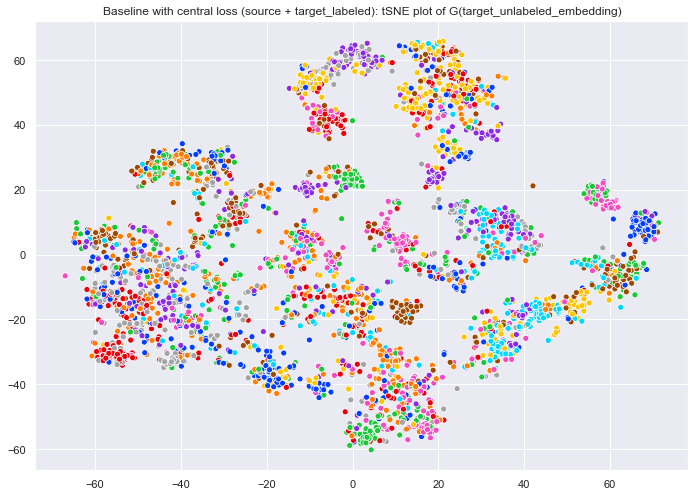

In [50]:
# plot 
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 65)

g = sns.scatterplot(target_embedded[:,0], target_embedded[:,1], hue=target_unlabel_y, legend=False, palette=palette)

plt.title('Baseline with central loss (source + target_labeled): tSNE plot of G(target_unlabeled_embedding)')

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns 
import matplotlib.pyplot as plt

def tSNE(fake_source_embedding_all, ):
    """
    fake_source_embedding_all: torch.Size([3575, 500])
    
    """
    tsne = TSNE()
    target_embedded = tsne.fit_transform(fake_source_embedding_all.detach())

# GAN local acc37

## Model

In [43]:

class Generator(nn.Module):
    def __init__(self, dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, dim),
            nn.LayerNorm(dim),
        ) 

    def forward(self, x):
        return self.net(x)




def classifier_inference(encoder, CNet, x, x_mean_tr, x_std_tr):
    CNet.eval()
    encoder.eval()
    with torch.no_grad():
        #normalize data
        x = (x - x_mean_tr) / x_std_tr
        # take the real and imaginary part out
        real = x[:,:,0].reshape(args.batch_size, seq_len, feature_dim).float()
        imag = x[:,:,1].reshape(args.batch_size, seq_len, feature_dim).float()
        if torch.cuda.is_available():
            real.to(device)
            imag.to(device)
        real, imag = encoder(real, imag)
        pred = CNet(torch.cat((real, imag), -1).reshape(x.shape[0], -1))
    return pred





args.task = '3Av2' if args.task == '3A' else '3E'
d_out = 50 if args.task == "3Av2" else 65
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


seq_len = 10 
feature_dim = 160

CNet_path = "../train_related/pretrain/gan_local_acc37/CNet_996.t7"
encoder_path = "../train_related/pretrain/gan_local_acc37/encoder_pre_trained.t7"
GNet_path = "../train_related/pretrain/gan_local_acc37/GNet_996.t7"
DNet_local_path = "../train_related/pretrain/gan_local_acc37/DNet_local_996.t7"


encoder = ComplexTransformer(layers=3,
                               time_step=seq_len,
                               input_dim=feature_dim,
                               hidden_size=64,
                               output_dim=64,
                               num_heads=8,
                               out_dropout=0.2,
                               leaky_slope=0.2)
encoder.to(device)

CNet = FNN(d_in=64 * 2 * 1, d_h1=500, d_h2=500, d_out=num_class, dp=0.2)
CNet.to(device)

DNet_global = Discriminator(feature_dim=64*2, d_out=1).to(device)
DNet_local = Discriminator(feature_dim=64*2, d_out=num_class).to(device)
GNet = Generator(dim=64*2).to(device)
DNet_global.apply(weights_init)
DNet_local.apply(weights_init)
GNet.apply(weights_init)
encoder.apply(weights_init)
CNet.apply(weights_init)

if torch.cuda.is_available():
    CNet.load_state_dict(torch.load(CNet_path))
    encoder.load_state_dict(torch.load(encoder_path))
    GNet.load_state_dict(torch.load(GNet_path))
    DNet_local.load_state_dict(torch.load(DNet_local_path))
else:
    CNet.load_state_dict(torch.load(CNet_path, map_location=torch.device('cpu')))
    encoder.load_state_dict(torch.load(encoder_path, map_location=torch.device('cpu')))
    GNet.load_state_dict(torch.load(GNet_path, map_location=torch.device('cpu')))
    DNet_local.load_state_dict(torch.load(DNet_local_path, map_location=torch.device('cpu')))

In [44]:
# weights = torch.load(GNet_path, map_location=torch.device('cpu'))
# for i, j in weights.items():
#     print("%s: %s"%(i,j.shape))

In [46]:

def encoder_inference_gan(encoder, x):
    real = x[:,:,0].reshape(x.size(0), seq_len, feature_dim).float()
    imag = x[:,:,1].reshape(x.size(0), seq_len, feature_dim).float()
    real, imag = encoder(real, imag)
    return torch.cat((real[:,-1,:], imag[:,-1,:]), -1).reshape(x.shape[0], -1)



target_x_embedding_all = encoder_inference_gan(encoder, torch.tensor(target_unlabel_x))
fake_source_embedding = GNet(target_x_embedding_all)


In [47]:
tsne = TSNE()
tsne_target_embedded_all_gan = tsne.fit_transform(fake_source_embedding.detach())

Text(0.5, 1.0, 'Using GAN: tSNE plot of GNet(target_unlabeled_embedding)')

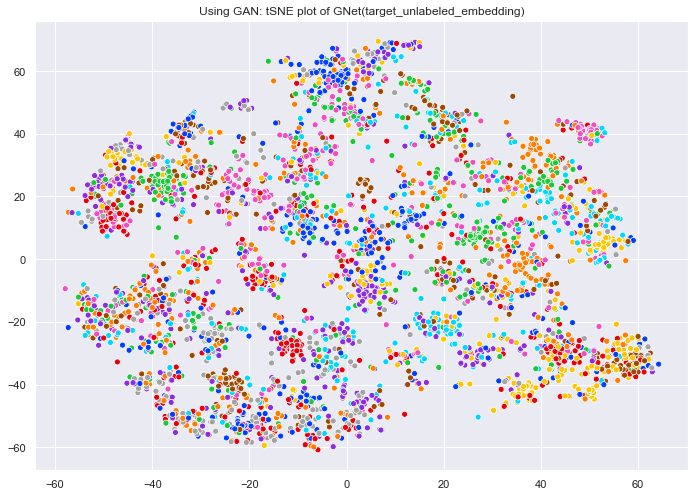

In [49]:
# plot 
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 65)

g = sns.scatterplot(tsne_target_embedded_all_gan[:,0], tsne_target_embedded_all_gan[:,1], hue=target_unlabel_y, legend=False, palette=palette)

plt.title('Using GAN: tSNE plot of GNet(target_unlabeled_embedding)')

# Probability Classifier + linear

## Model

In [13]:
def encoder_inference(encoder, encoder_MLP, x):
    real = x[:,:,0].reshape(x.size(0), seq_len, feature_dim).float()
    imag = x[:,:,1].reshape(x.size(0), seq_len, feature_dim).float()
    real, imag = encoder(real, imag)
    cat_embedding = torch.cat((real[:,-1,:], imag[:,-1,:]), -1).reshape(x.shape[0], -1)
    cat_embedding = encoder_MLP(cat_embedding)
    return cat_embedding


device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')
print(device)

seq_len = 10
feature_dim = 160
encoder = ComplexTransformer(layers=3,
                               time_step=seq_len,
                               input_dim=feature_dim,
                               hidden_size=64,
                               output_dim=64,
                               num_heads=8,
                               out_dropout=0.2,
                               leaky_slope=0.2).to(device)
encoder_MLP = FNNSeparated(d_in=64 * 2 * 1, d_h1=500, d_h2=500, dp=0.2).to(device)
CNet = FNNLinear(d_h2=500, d_out=num_class).to(device)
GNet = Generator(dim=500).to(device)

criterion_classifier = nn.CrossEntropyLoss().to(device)
criterion_centerloss = CenterLoss(num_classes=num_class, feat_dim=500, use_gpu=torch.cuda.is_available()).to(device)
# criterion_probloss = BinaryLoss(device).to(device)

GNet.apply(weights_init)
encoder.apply(weights_init)
encoder_MLP.apply(weights_init)
CNet.apply(weights_init)

optimizerG = torch.optim.Adam(GNet.parameters(), lr=args.lr_gan)
optimizerCNet = torch.optim.Adam(CNet.parameters(), lr=args.lr_FNN)
optimizerEncoderMLP = torch.optim.Adam(encoder_MLP.parameters(), lr=args.lr_encoder)
optimizerEncoder = torch.optim.Adam(encoder.parameters(), lr=args.lr_encoder)
optimizerCenterLoss = torch.optim.Adam(criterion_centerloss.parameters(), lr=args.lr_centerloss)



cpu


In [14]:

# pre-trained
select_pretrain_epoch = 180
# sbinary = 1
model_PATH = '../train_related/pretrain/binary_balance_linear_acc49'
CNet.load_state_dict(torch.load(model_PATH+'/CNet_{}.t7'.format(select_pretrain_epoch), map_location=device))
encoder.load_state_dict(torch.load(model_PATH+'/encoder_{}.t7'.format(select_pretrain_epoch), map_location=device))
encoder_MLP.load_state_dict(torch.load(model_PATH+'/encoder_MLP_{}.t7'.format(select_pretrain_epoch), map_location=device))
GNet.load_state_dict(torch.load(model_PATH+'/GNet_{}.t7'.format(select_pretrain_epoch), map_location=device))

correct_target = 0.0
num_datas = 0.0
CNet.eval()
encoder.eval()
encoder_MLP.eval()
GNet.eval()


Generator(
  (net): Sequential(
    (0): Linear(in_features=500, out_features=300, bias=True)
    (1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=300, out_features=500, bias=True)
    (4): LayerNorm((500,), eps=1e-05, elementwise_affine=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): LayerNorm((500,), eps=1e-05, elementwise_affine=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=500, out_features=300, bias=True)
    (10): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Linear(in_features=300, out_features=500, bias=True)
    (13): LayerNorm((500,), eps=1e-05, elementwise_affine=True)
  )
)

In [23]:
binary_target_unlabel_x_embedding_all = encoder_inference(encoder, encoder_MLP, torch.tensor(target_unlabel_x))
binary_fake_source_embedding_all = GNet(binary_target_unlabel_x_embedding_all)


In [24]:
tsne = TSNE()
binary_target_embedded = tsne.fit_transform(binary_fake_source_embedding_all.detach())

Text(0.5, 1.0, 'Probability Classifier: tSNE plot of G(target_unlabeled_embedding)')

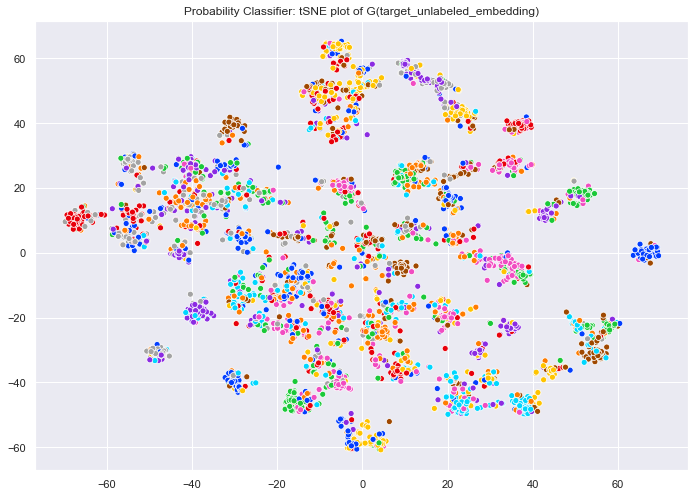

In [25]:
# plot 
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 65)

g = sns.scatterplot(binary_target_embedded[:,0], binary_target_embedded[:,1], hue=target_unlabel_y, legend=False, palette=palette)

plt.title('Probability Classifier: tSNE plot of G(target_unlabeled_embedding)')

### Source Data

In [15]:
raw_data = np.load(args.data_path+'/processed_file_not_one_hot_%s.pkl'%args.task, allow_pickle=True)
source_data = raw_data['tr_data']

In [21]:
s_index = torch.randperm(source_data.shape[0])[:3750]

s_index.shape

torch.Size([3750])

In [22]:
s_index = torch.randperm(source_data.shape[0])[:3750]

source_x = source_data[s_index]
source_y = raw_data['tr_lbl'][s_index]

source_binary_target_unlabel_x_embedding_all = encoder_inference(encoder, encoder_MLP, torch.tensor(source_x))
source_binary_fake_source_embedding_all = GNet(source_binary_target_unlabel_x_embedding_all)


In [2]:
source_binary_fake_source_embedding_all

NameError: name 'source_binary_fake_source_embedding_all' is not defined

In [ ]:
tsne = TSNE()
binary_target_embedded = tsne.fit_transform(binary_fake_source_embedding_all.detach())

In [ ]:
# plot 
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 65)

g = sns.scatterplot(binary_target_embedded[:,0], binary_target_embedded[:,1], hue=target_unlabel_y, legend=False, palette=palette)

plt.title('Baseline with central loss (source + target_labeled): tSNE plot of G(target_unlabeled_embedding)')

In [18]:
target_unlabel_x.shape

(3575, 1600, 2)

In [42]:
source_data_x = raw_data['tr_data']
source_data_y = raw_data['tr_lbl']

In [43]:
torch.manual_seed(123)
source_data_x_index = torch.randperm(source_data_x.shape[0])[:target_unlabel_x.shape[0]]

In [69]:
source_data_x_p = source_data_x[source_data_x_index]

In [64]:
source_data_y_p = source_data_y[source_data_x_index]
source_data_y_p

array([49, 19, 39, ...,  4, 42, 21])

tensor([11686,  6770,  5087,  ..., 12276,  7100,  8280])

39

In [70]:
s_binary_target_unlabel_x_embedding_all = encoder_inference(encoder, encoder_MLP, torch.tensor(source_data_x_p))



In [52]:
tsne = TSNE()
s_binary_target_embedded = tsne.fit_transform(s_binary_target_unlabel_x_embedding_all.detach())

Text(0.5, 1.0, 'Probability Classifier: tSNE plot of G(source_embedding)')

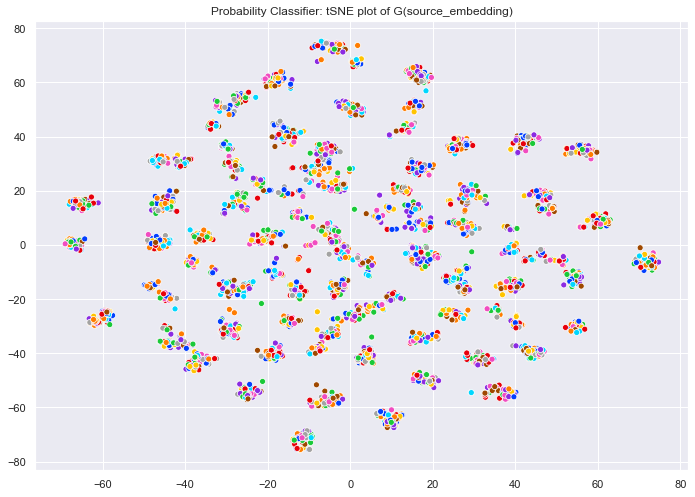

In [61]:
# plot 
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 65)

source_data_x_index = torch.randperm(source_data_x.shape[0])[:target_unlabel_x.shape[0]]
source_data_x_p = source_data_x[source_data_x_index]
g = sns.scatterplot(s_binary_target_unlabel_x_embedding_all[:,0], s_binary_target_unlabel_x_embedding_all[:,1], hue=source_data_y_p, legend=False, palette=palette)

plt.title('Probability Classifier: tSNE plot of G(source_embedding)')

In [ ]:
# get only the first 10 class

